## ROC
* Receiver Operation Characteristic
* 수신자 판단 곡선 
* 세계 2차 대전 통신 장비 성능 평가를 위해 고안된 수치
    + 레이더 데이터를 분석하여 적 항공기와 신호 소음을 구별하는 데 사용
    + 수신기의 감도가 증가함에 따라 거짓 긍정의 수(즉, 특이성)이 감소함
* 의학분야에 많이 사용되지만, 머신러닝의 이진 분류 모델 예측 성능 평가에도 사용
* ROC곡선의 y축은 '재현율TPR'를, x축은 '(1-재현율)FPR'로 그림
    + FPR : FP/(TN+FP) : 아군항공기 소리를 적항공기 소리라고 오판한 비율 - 낮아야 함
    + TPR : TP/(TP+FN) : 적항공기 소리를 적항공기 소리라고 잘판단한 비율 - 높아야 함
    + FPR이 변할때 TPR이 어떻게 변하는지 알아봄
* 모델이 양성/긍정으로 예측했을때 얼마나 잘 맞추고 있는지를 설명한 것

### ROC 그래프 그리기
* 타이타닉 데이터셋으로 로지스틱회귀 분석한 후
* 특이도, 재현율을 구한후 ROC 그래프 작성

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [3]:
titanic = pd.read_csv('titanic3.csv')
data = titanic.iloc[:, 1:8]
target = titanic.survived
X_train, X_test, y_train, y_test= train_test_split(data, target, train_size=0.7,
                random_state=2309221500, stratify=target)

In [4]:
lrclf = LogisticRegression(max_iter=500)

lrclf.fit(X_train, y_train)
pred = lrclf.predict(X_test)
accuracy_score(y_test, pred)

0.7678571428571429

### 분류모델의 불확실성 알아보기
* 확률적 판별/생성 모형 
    + 주어진 데이터에 대해 각 범주category/레이블이 정답일 조건부확률을 계산하는 방법에 따라 **조건부 확률함수를 추정**하거나 베이즈 정리를 사용해서 분류하는 모형
* 따라서, 분류기의 **예측 불확실성**을 추정하려면 scikit-learn에서 제공하는 2가지 함수를 사용
     + decision function, `predict_proba`

In [5]:
X_test[:3]

,age,sibsp,parch,fare,gender,embark_town,pclass
933,29.000000,3.0,1.0,22.0250,1,2,2
996,29.881135,0.0,0.0,7.8958,1,0,2
414,16.000000,0.0,0.0,26.0000,1,2,1


In [6]:
# 생존여부를 이산형 수치로 확인
lrclf.predict(X_test[:3])

array([0, 0, 0])

In [7]:
# 생존여부를 확률수치로 확인
lrclf.predict_proba(X_test[:3])

array([[0.95993164, 0.04006836],
       [0.84506438, 0.15493562],
       [0.68139296, 0.31860704]])

### 타이타닉 승객 생존 여부 확률값 추출
+ 타이타닉 승객 생존 여부에서 `생존(1)`이 주된 관심사이므로
+ 생존에 대한 확률값만 따로 추출

In [8]:
pred_proba = lrclf.predict_proba(X_test)
pred_proba[:3, 1]  # 승객의 생존에 대한 확률값(0.5 이상 생존, 0.5이하 사망)

array([0.04006836, 0.15493562, 0.31860704])

In [9]:
# 실제값, 확률값, 예측값을 하나의 데이터프레임으로 작성
table = pd.DataFrame()

table['실제값'] = y_test
table['생존확률값'] = pred_proba[:, 1]
table['예측값'] = lrclf.predict(X_test)

table.head()

,실제값,생존확률값,예측값
933,1,0.040068,0
996,0,0.154936,0
414,0,0.318607,0
528,0,0.291127,0
1220,0,0.141173,0


### 각 예측값 별 특이도fprs, 재현율tprs, 임계값을 구함
+ tprs : 실제값이 양성(승객 생존)이고 예측값이 양성(승객 생존)으로 예측되는 정도
+ fprs : 실제값이 음성(승객 사망)인데 예측값이 양성(승객 생존)으로 예측되는 정도
+ thresholds : 임계값

In [10]:
from sklearn.metrics import roc_curve

In [11]:
fprs, tprs, thresholds = roc_curve(y_test, pred_proba[:, 1])

print('양성tprs 결과', tprs[:5])
print('음성fprs 결과', fprs[:5])

양성tprs 결과 [0.         0.00671141 0.34899329 0.34899329 0.40268456]
음성fprs 결과 [0.         0.         0.         0.00411523 0.00411523]


### ROC 그래프 시각화
+ 분류를 잘 하는 모델일수록 커브는 1에 가깝게 표시
+ fpr, tpr 그래프의 겹친 부분이 크다 - 변별력 낮음 - 곡선이 0에 가깝게 붙어서 출력
+ fpr, tpr 그래프가 겹친 부분이 작다 - 변별력 높음 - 곡선이 1에 가깝게 붙어서 출력

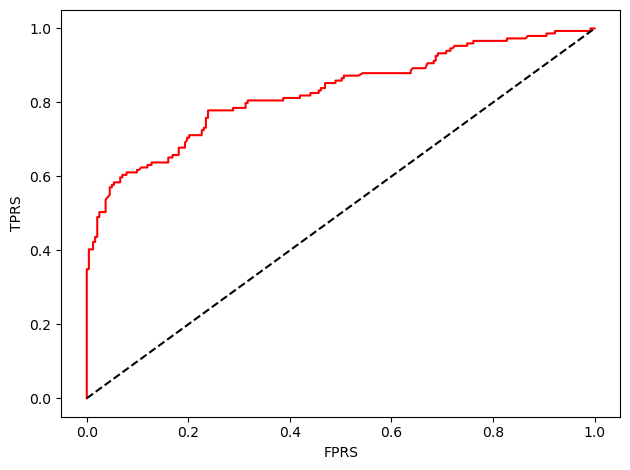

In [12]:
plt.plot(fprs, tprs, 'r')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('FPRS')
plt.ylabel('TPRS')
plt.tight_layout()

### 특이도, 재현율 시각화
<img src='./img/tpr_fpr_threshold.png'>

In [13]:
roc = pd.DataFrame()

roc['fprs'] = fprs
roc['tprs'] = tprs
roc['thresholds'] = thresholds

roc.head()

,fprs,tprs,thresholds
0,0.000000,0.000000,1.956032
1,0.000000,0.006711,0.956032
2,0.000000,0.348993,0.779096
3,0.004115,0.348993,0.776471
4,0.004115,0.402685,0.734301


In [14]:
roc.tail()

,fprs,tprs,thresholds
125,0.921811,0.986577,0.072240
126,0.921811,0.993289,0.071497
127,0.991770,0.993289,0.048724
128,0.991770,1.000000,0.040068
129,1.000000,1.000000,0.007980


### fpr, tpr 관계
<img src='./img/TP-TN-FP-FN.png'>

In [15]:
import seaborn as sns

/opt/conda/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_8787/3253261754.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


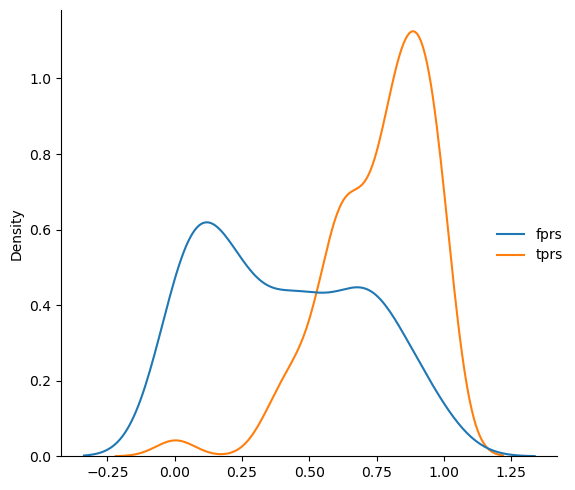

In [16]:
sns.displot(roc.iloc[:, [0,1]], kind='kde')
plt.tight_layout()

## AUC
* Area Under Curve
* ROC 곡선 밑의 면적을 구한 값
* 1에 가까울 수록 좋은 수치를 의미함
    + 0.9 ~ 1 : excellent
    + 0.8 ~ 0.9 : good
    + 0.7 ~ 0.8 : normal

In [17]:
from sklearn.metrics import roc_auc_score

In [18]:
roc_auc_score(y_test, pred)

0.7426602590659265